In [563]:
import pandas as pd 
import numpy as np
from langdetect import detect
import seaborn as sns
import io 
import matplotlib.pyplot as plt

from datetime import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [564]:
cd '/Users/admin/Jedha/'

/Users/admin/Jedha


In [565]:
# full_dataset_reworked
obj = s3.Object('jedha-fake-reviews-project', "datasets/full_dataset.csv")
dataset = pd.read_csv(io.BytesIO(obj.get()['Body'].read()), low_memory = False, index_col=0)

In [566]:
#_____________________________________________________________________
######### Cleaning the dataset and adding new columns #########
#_____________________________________________________________________

#we drop rows in which restaurant infos are not available (miss scraped)
dataset = dataset.dropna(subset = ['restaurant_average_rating', 'restaurant_reviews_count', 'restaurant_expensiveness', 'restaurant_name'])

#adding a column with the length of the text review
dataset['text_length'] = dataset['text_review'].apply(lambda x : len(x))

#_____________________________________________________________________
######### Fixing existing columns values and types #########
#_____________________________________________________________________

#for the user_total_image_posted column, if user_total_image_posted is NA it means there is there's no image
    # so we set the value to 0
dataset.loc[dataset['user_total_image_posted'].isna(), 'user_total_image_posted'] = 0

#for the date column,  there is some miss scraps that we want to fix
    # a correct data must have a length of 10 , if it is smaller than 10 it's becasue we scrapped the number of images of the user instead
    # we may have to scrap again those lines to fix it
    # we keep only the rows where the date is correct 
mask_not_date = dataset['date'].apply(lambda x: len(x)) < 10
dataset = dataset.loc[mask_not_date == False, :]
    # if te length is greater than 10 is it is beacause we scraped the date + somme additional words ('Avis mis à jour') so we will keep only the part with the date
mask_date_to_fix = dataset['date'].apply(lambda x: len(x)) > 10
dataset.loc[mask_date_to_fix, 'date' ] = dataset.loc[mask_date_to_fix, 'date' ].str.split('\n').str[0]
    #finally we can convert the date column to a datetime format
dataset['date'] = pd.to_datetime(dataset['date'])

#for the photos_for_review column, 
    # value -1 is in fact 0 (no photos found by the scraper)
dataset.loc[dataset['photos_for_review'] == '-1.0', 'photos_for_review' ] = '0'
    # value L is in fact 0 (no photos found by the scraper but scraped the first letter of "L'avis du jour" which happens when the reviews was updated by the user)
dataset.loc[dataset['photos_for_review'] == 'L', 'photos_for_review' ] = '0'
    # finally we can convert the photos_for_review column to an int format
dataset['photos_for_review'] = dataset['photos_for_review'].astype('int')

#for the photos_for_review column, 
    # when there's no info about the expensiveness we set it to -1
dataset.loc[dataset['restaurant_expensiveness'] == 'N/C', 'restaurant_expensiveness']  = -1
    # we can convert the restaurant_expensiveness column to an int format
dataset['restaurant_expensiveness'] = dataset['restaurant_expensiveness'].astype('int')

In [567]:
dataset['is_real_review'] = dataset['is_real_review'].apply(lambda x: 1 if x == 0 else 0)
dataset.rename(columns={'is_real_review': 'is_fake_review'}, inplace=True)

In [568]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 96731
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       90275 non-null  datetime64[ns]
 1   username                   90275 non-null  object        
 2   photos_for_review          90275 non-null  int64         
 3   rating                     90275 non-null  float64       
 4   text_review                90275 non-null  object        
 5   user_location              90271 non-null  object        
 6   user_friends_count         90275 non-null  int64         
 7   user_reviews_count         90275 non-null  int64         
 8   user_total_image_posted    90275 non-null  float64       
 9   restaurant_average_rating  90275 non-null  float64       
 10  restaurant_reviews_count   90275 non-null  float64       
 11  restaurant_expensiveness   90275 non-null  int64         
 12  rest

In [507]:
dataset.groupby('restaurant_expensiveness')['is_real_review'].mean()

restaurant_expensiveness
-1    0.807429
 1    0.796176
 2    0.806224
 3    0.834329
 4    0.850175
Name: is_real_review, dtype: float64

In [509]:
print('real_review | mean_user_review_count: ', dataset.loc[dataset['is_real_review']==1]['user_reviews_count'].mean())
print('fake_review | mean_user_review_count: ', dataset.loc[dataset['is_real_review']==0]['user_reviews_count'].mean())
print('-----------------------------------------------------------------------------------------')
print('real_review | mean_user_friend_count: ', dataset.loc[dataset['is_real_review']==1]['user_friends_count'].mean())
print('fake_review | mean_user_friend__count: ', dataset.loc[dataset['is_real_review']==0]['user_friends_count'].mean())
print('-----------------------------------------------------------------------------------------')
print('real_review | mean_user_image_posted_count: ', dataset.loc[dataset['is_real_review']==1]['user_total_image_posted'].mean())
print('fake_review | mean_user_image_posted_count: ', dataset.loc[dataset['is_real_review']==0]['user_total_image_posted'].mean())


real_review | mean_user_review_count:  94.08211482745956
fake_review | mean_user_review_count:  19.6696108856529
-----------------------------------------------------------------------------------------
real_review | mean_user_friend_count:  43.476652293964825
fake_review | mean_user_friend__count:  236.6317736930055
-----------------------------------------------------------------------------------------
real_review | mean_user_image_posted_count:  167.98895523606143
fake_review | mean_user_image_posted_count:  11.312604440200525


In [510]:
subdata = dataset.loc[:, ['date','is_real_review']]

In [511]:
subdata['year'] = subdata['date'].dt.year
subdata['month'] = subdata['date'].dt.month
subdata['day_name'] = subdata['date'].dt.day_name()
subdata['day'] = subdata['date'].dt.day

In [512]:
subdata.head()

,date,is_real_review,year,month,day_name,day
0,2007-08-21,1.0,2007,8,Tuesday,21
2,2006-07-26,1.0,2006,7,Wednesday,26
3,2004-10-14,1.0,2004,10,Thursday,14
4,2007-11-02,1.0,2007,11,Friday,2
5,2012-04-25,1.0,2012,4,Wednesday,25


In [513]:
dataset['language'].value_counts()

fr           85687
en            4049
de              91
es              90
it              80
ca              51
pt              38
nl              34
zh-cn           31
da              17
ro              11
af              10
id              10
sv               8
not_found        8
no               7
tl               7
pl               6
so               5
ja               5
lt               4
cy               4
hr               3
tr               3
fi               3
sl               2
cs               2
hu               2
sq               2
lv               2
sw               1
ko               1
et               1
Name: language, dtype: int64

In [519]:
mask_is_not_fr_en = (dataset['language'] != 'fr') & (dataset['language'] != 'en')
dataset.loc[mask_is_not_fr_en ,'language'] = 'other'

In [521]:
dataset['language'].value_counts()

fr       85687
en        4049
other      539
Name: language, dtype: int64

<AxesSubplot:xlabel='language', ylabel='Count'>

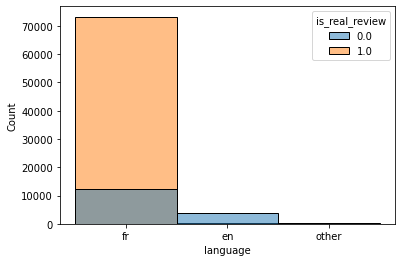

In [525]:
sns.histplot(data = dataset, x = 'language', hue = 'is_real_review')

In [523]:
dataset.groupby('language')['is_real_review'].mean()

language
en       0.050630
fr       0.854575
other    0.163265
Name: is_real_review, dtype: float64

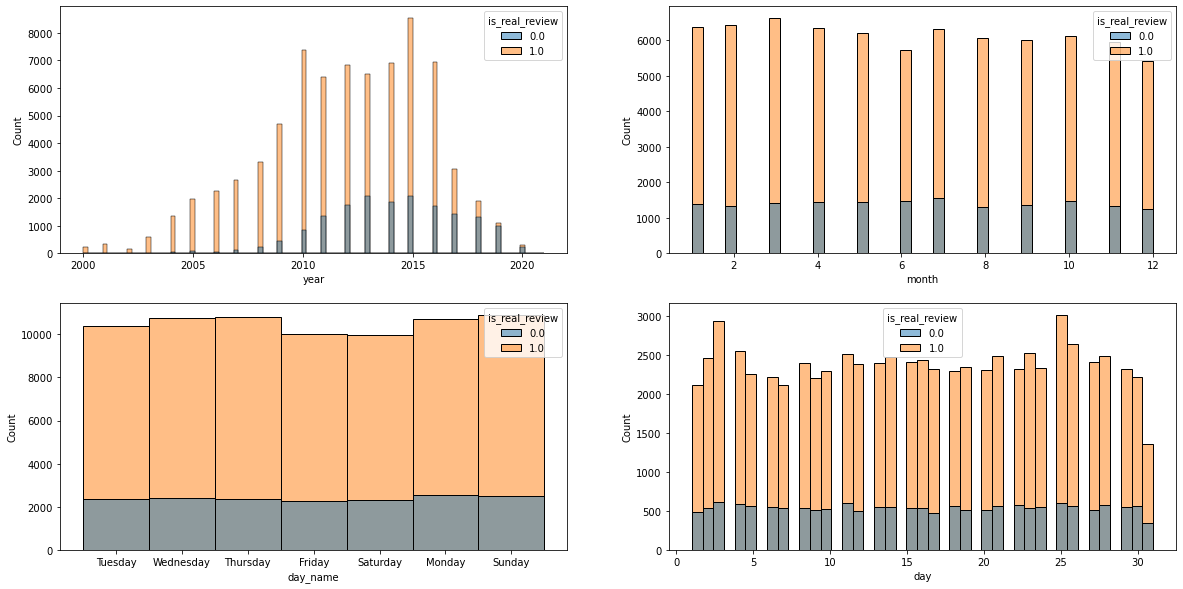

In [408]:
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,10) )

ax1 = sns.histplot(data = subdata, x = 'year', hue = 'is_real_review', ax = ax1)
ax2 = sns.histplot(data = subdata, x = 'month', hue = 'is_real_review', ax = ax2)
ax3 = sns.histplot(data = subdata, x = 'day_name', hue = 'is_real_review', ax = ax3)
ax4 = sns.histplot(data = subdata, x = 'day', hue = 'is_real_review', ax = ax4)

In [527]:
X = dataset[[c for c in dataset.columns if c not in ['date', 'username', 'text_review', 'user_location', 'restaurant_name', 'url', 'is_real_review', 'url_not_recommended']]]
y = dataset['is_real_review']

numeric_features = [index for index, c in enumerate(X.columns) if X[c].dtype != 'object']
categorical_features = [index for index, c in enumerate(X.columns) if X[c].dtype == 'object']

X = X.values
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=19, stratify = y)



In [528]:

# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)

# Preprocessings on test set
X_test = preprocessor.transform(X_test) 

In [534]:
# Train model
model = LogisticRegression(C=0.95, class_weight={0:0.684, 1:1}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


model.fit(X_train, y_train)


LogisticRegression(C=0.95, class_weight={0: 0.684, 1: 1})

In [536]:

print(classification_report(y_true=y_test, y_pred=model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.28      0.43      3351
         1.0       0.86      1.00      0.92     14704

    accuracy                           0.86     18055
   macro avg       0.90      0.64      0.68     18055
weighted avg       0.87      0.86      0.83     18055



In [ ]:
# grid search class weights with logistic regression for imbalance classification
from numpy import mean
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# define grid
#cw_params = [{0:0.672,1:1}, {0:0.68,1:1}]
cw_params = [{0:i, 1:1} for i in np.arange(0.67, 0.69, 0.001)]
C_params = np.arange(0.9,1,0.01)
#C_params = [0.9]
param_grid = dict(class_weight = cw_params, C = C_params)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X_test, Y_test)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))